# XG Boosted Trees for sex prediction

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from statsmodels.tsa import stattools
from sklearn import preprocessing
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
feats = np.load('Sex_feats_15_aligned.npy')
labels = np.load('../processed_datasets/Sex_y_15_aligned.npy')
ids = np.load('../processed_datasets/Sex_ids_15_aligned.npy')
feats.shape, labels.shape, ids.shape

((541954, 14, 15), (541954,), (541954,))

In [3]:
labels = labels == 'Male'
labels

array([False, False, False, ...,  True,  True,  True])

In [ ]:
#Optional, select only accel and gyro
feats = feats[:, :, [0, 1, 2, 4, 5, 6]]
feats.shape

In [4]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#Flatten the features
feats = feats.reshape((feats.shape[0], -1))

#Remove nans
valid_idxs = ~np.isnan(feats).any(axis=1)
feats = feats[valid_idxs]
labels = labels[valid_idxs]
ids = ids[valid_idxs]

print(feats.shape, labels.shape)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels, train_ids, test_ids = train_test_split(feats, labels, ids, test_size = 0.1, random_state = 42, shuffle = False)
train_features, val_features, train_labels, val_labels, train_ids, val_ids = train_test_split(train_features, train_labels, train_ids, test_size = 2/9, random_state = 42, shuffle = False)
#Scale the features
train_features_scaled = preprocessing.scale(train_features)
test_features_scaled = preprocessing.scale(test_features)
val_features_scaled = preprocessing.scale(val_features)


print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Val Features Shape:', val_features_scaled.shape)
print('Val Labels Shape:', val_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

(540054, 210) (540054,)
Training Features Shape: (378037, 210)
Training Labels Shape: (378037,)
Val Features Shape: (108011, 210)
Val Labels Shape: (108011,)
Testing Features Shape: (54006, 210)
Testing Labels Shape: (54006,)


In [5]:
#Optional, balance the dataset
false_idx = np.nonzero(train_labels == False)[0]
true_idx = np.nonzero(train_labels)[0]
print(len(false_idx), len(true_idx))
num_to_take = min(len(false_idx), len(true_idx))

valid_idx = np.concatenate((false_idx[:num_to_take], true_idx[:num_to_take]))
np.random.shuffle(valid_idx)

train_features_scaled = train_features_scaled[valid_idx]
train_labels = train_labels[valid_idx]
train_ids = train_ids[valid_idx]
print(train_ids.shape)

93847 284190
(187694,)


In [6]:
# The baseline predictions are the train set averages
baseline_preds = np.zeros_like(train_labels) + np.mean(train_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - train_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.5


In [8]:
# Import the model we are using
from xgboost import XGBRegressor
# Instantiate model
model = XGBRegressor(n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=0, reg_lambda=1, tree_method='gpu_exact')
model.fit(train_features_scaled, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             verbosity=1)

In [9]:
# Use the model's predict method on the train data
predictions = model.predict(train_features_scaled)
acc = np.round(predictions) == train_labels
print('Train Accuracy:', np.mean(acc))

Train Accuracy: 0.7721077924707236


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

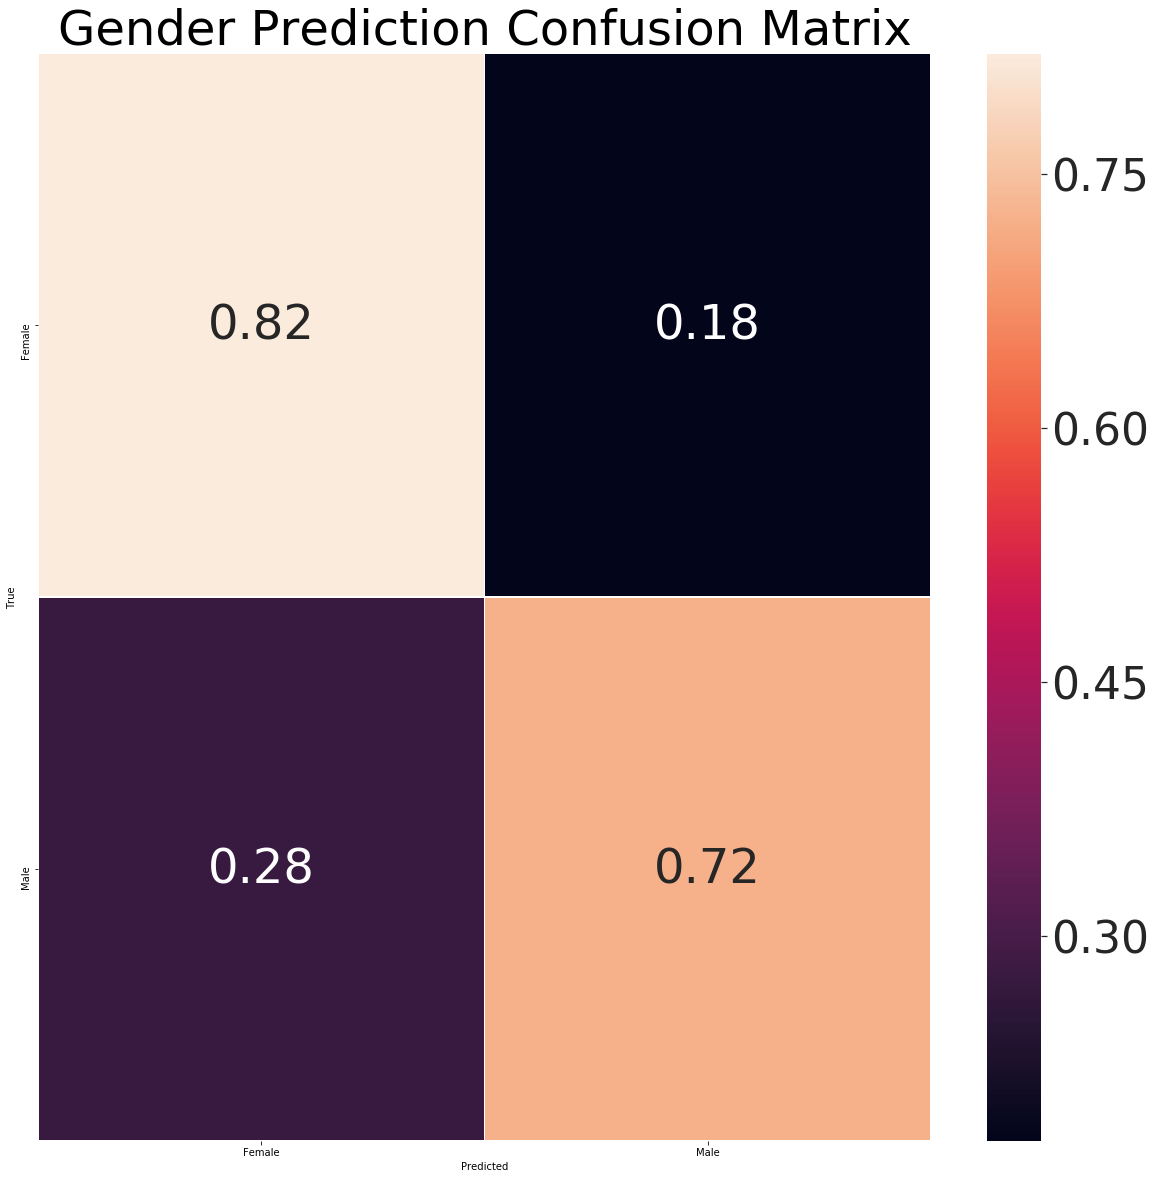

In [10]:
#Print confusion matrix
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((train_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

In [11]:
# Use the model's predict method on the val data
predictions = model.predict(val_features_scaled)
acc = np.round(predictions) == val_labels
print('Test Accuracy:', np.mean(acc))

Test Accuracy: 0.6563590745387043


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

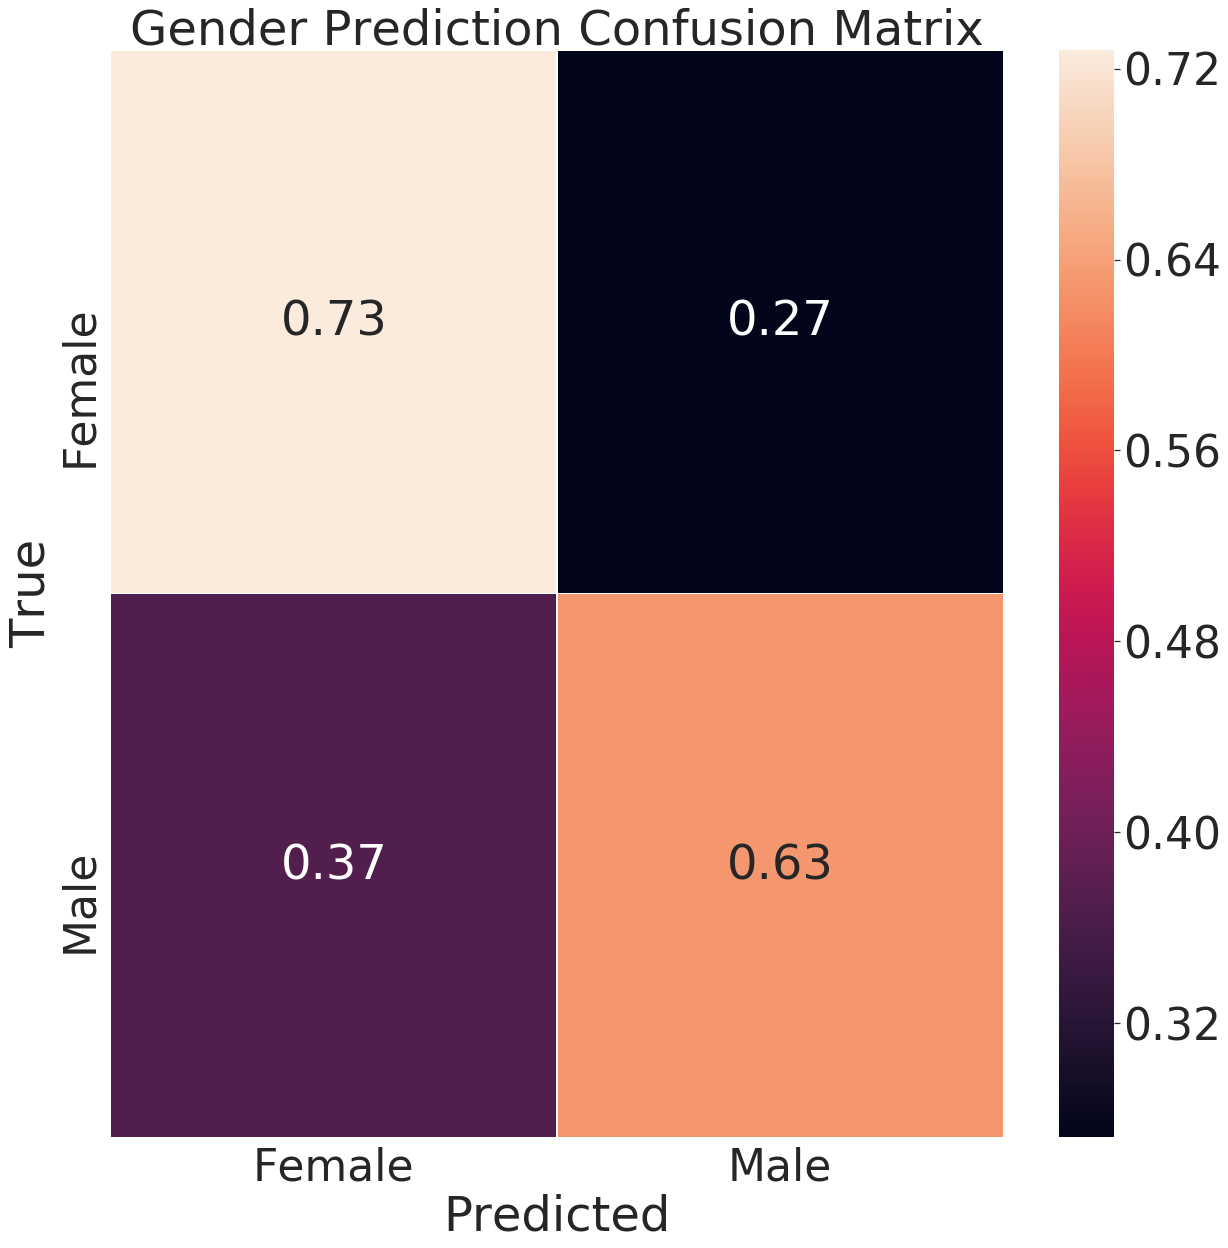

In [12]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((val_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

In [13]:
feature_list = np.arange(210)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                  122 Importance: 0.044189948588609695
Variable:                  121 Importance: 0.035628240555524826
Variable:                   63 Importance: 0.028860006481409073
Variable:                   17 Importance: 0.024231597781181335
Variable:                  107 Importance: 0.023996500298380852
Variable:                    7 Importance: 0.021099360659718513
Variable:                  106 Importance: 0.017468774691224098
Variable:                  155 Importance: 0.01677880436182022
Variable:                  157 Importance: 0.016743812710046768
Variable:                   14 Importance: 0.01623757928609848
Variable:                   94 Importance: 0.014368217438459396
Variable:                  120 Importance: 0.014301523566246033
Variable:                  154 Importance: 0.013911928050220013
Variable:                   28 Importance: 0.013874922879040241
Variable:                   55 Importance: 0.013183390721678734
Variable:                  185 Importance:

AUROC: 0.7456573304513935


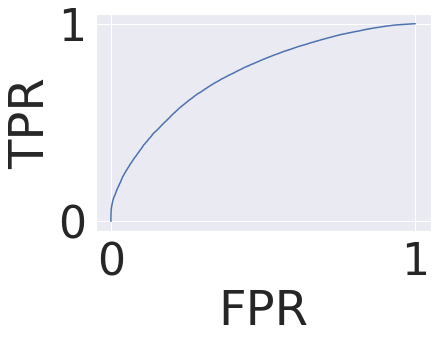

EER Threshold: 0.47582823 EER:  0.3197338777809068


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

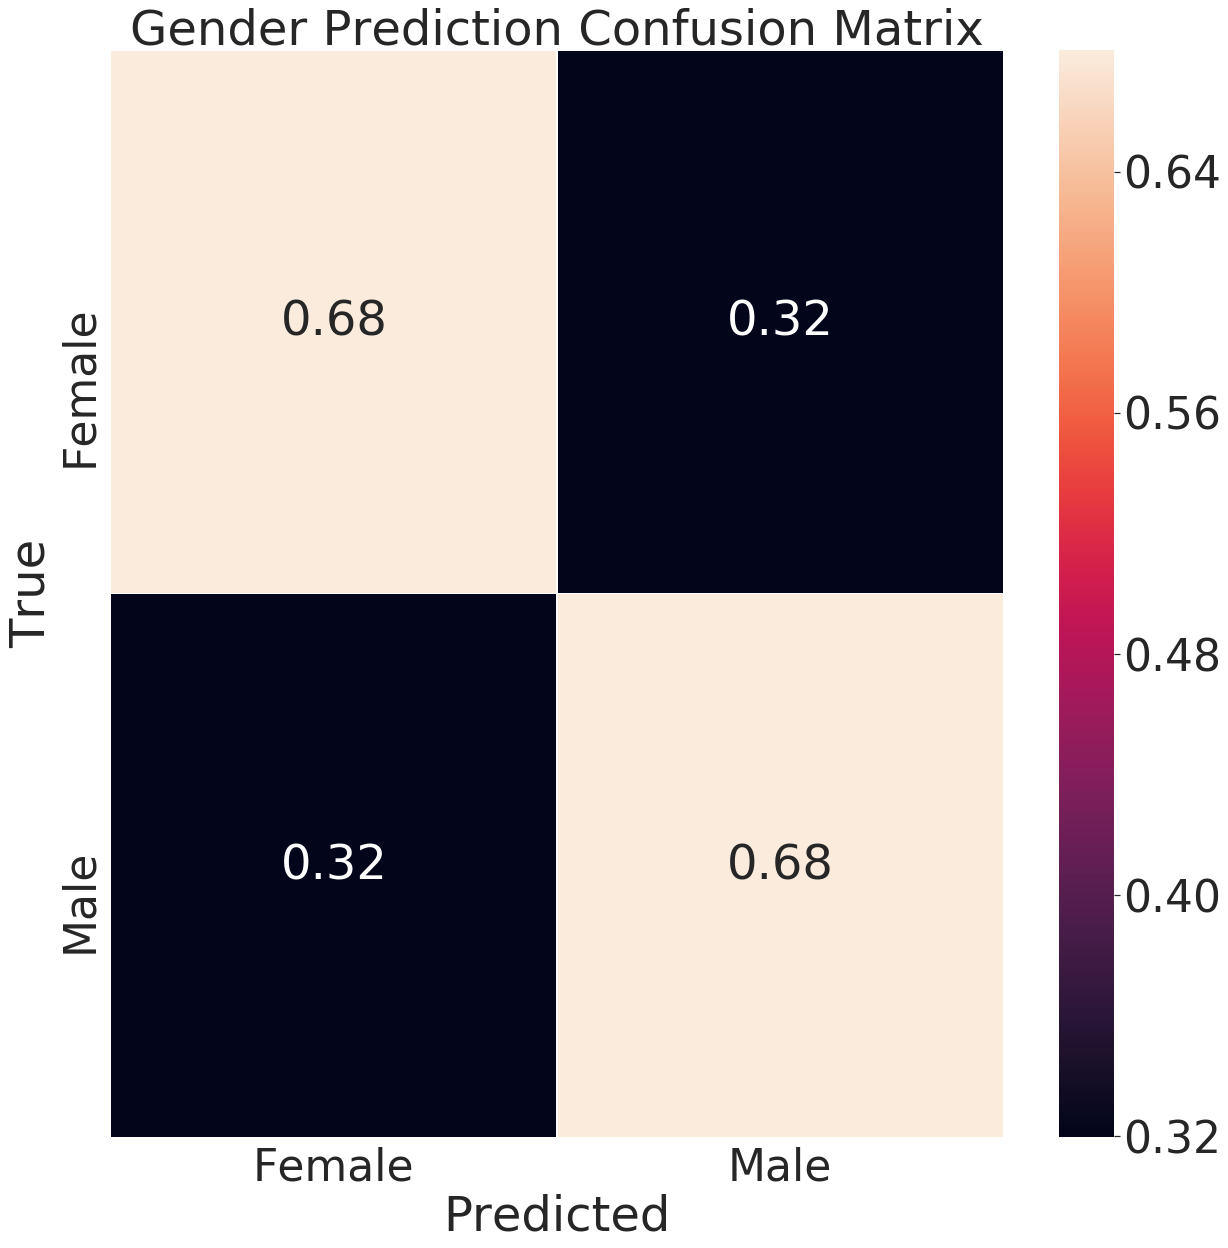

In [14]:
#ROC curve
from sklearn import metrics
y_score = model.predict(val_features_scaled)
fpr, tpr, threshs = metrics.roc_curve(val_labels, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(val_labels, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

fnr = 1 - tpr
eer_threshold = threshs[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER Threshold:", eer_threshold, "EER: ", EER)

fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((val_labels,y_score > eer_threshold)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# Userwise Accuracy

In [15]:
y_round = model.predict(test_features_scaled) > eer_threshold
thresh = 0.5
unique_ids = np.unique(test_ids)
print(f'There are {len(unique_ids)} unique ids in our test set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(test_ids == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > thresh
    true = y_round[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

There are 386 unique ids in our test set.


In [16]:
np.sum(overall_acc)/len(overall_acc), np.sum(female_acc)/len(female_acc), np.sum(male_acc)/len(male_acc)

(0.7772020725388601, 0.6879432624113475, 0.8285714285714286)